<a href="https://colab.research.google.com/github/VarunHarish98/ComputerVision/blob/main/Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2018 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Image classification

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/images/classification"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/classification.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/images/classification.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/images/classification.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial shows how to classify images of flowers using a `tf.keras.Sequential` model and load data using `tf.keras.utils.image_dataset_from_directory`. It demonstrates the following concepts:


* Efficiently loading a dataset off disk.
* Identifying overfitting and applying techniques to mitigate it, including data augmentation and dropout.

This tutorial follows a basic machine learning workflow:

1. Examine and understand data
2. Build an input pipeline
3. Build the model
4. Train the model
5. Test the model
6. Improve the model and repeat the process

In addition, the notebook demonstrates how to convert a [saved model](../../../guide/saved_model.ipynb) to a [TensorFlow Lite](https://www.tensorflow.org/lite/) model for on-device machine learning on mobile, embedded, and IoT devices.

## Setup

Import TensorFlow and other necessary libraries:

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Download and explore the dataset

This tutorial uses a dataset of about 3,700 photos of flowers. The dataset contains five sub-directories, one per class:

```
flower_photo/
  daisy/
  dandelion/
  roses/
  sunflowers/
  tulips/
```

In [ ]:
import pathlib

dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos.tar', origin=dataset_url, extract=True)
data_dir = pathlib.Path(data_dir).with_suffix('')

228813984/228813984 [==============================] - 2s 0us/step


After downloading, you should now have a copy of the dataset available. There are 3,670 total images:

In [ ]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


Here are some roses:

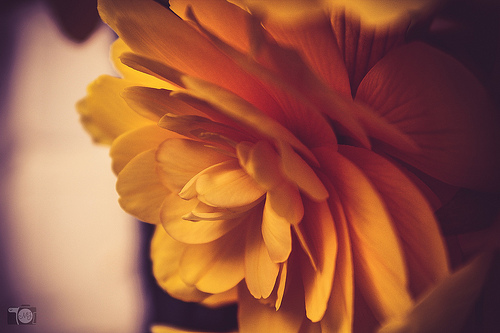

In [ ]:
# Display the list of images from roses, dandelion, tulips, sunflowers and daisy
# Here, roses are selected, can be used for other flowers too!

roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))
# dandelion = list(data_dir.glob('dandelion/*'))
# PIL.Image.open(str(dandelion[0]))
# tulips = list(data_dir.glob('tulips/*'))
# PIL.Image.open(str(tulips[0]))
# sunflowers = list(data_dir.glob('sunflowers/*'))
# PIL.Image.open(str(sunflowers[0]))
# daisy = list(data_dir.glob('daisy/*'))
# PIL.Image.open(str(daisy[0]))

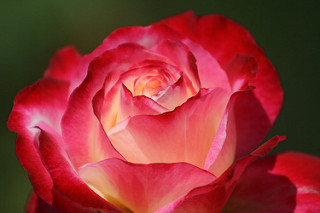

In [ ]:
PIL.Image.open(str(roses[5]))

And some tulips:

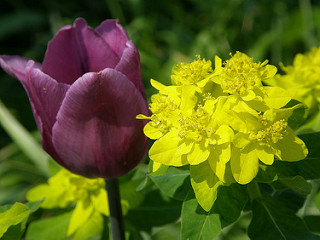

In [ ]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

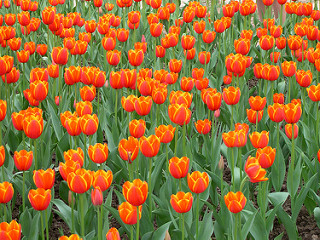

In [ ]:
PIL.Image.open(str(tulips[1]))

We have imported as set of 3670 images from the https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz ,we need to use them from the disk. <br>
We use <b>"tf.keras.utils.image_dataset_from_directory"</b> utility function
<ol>
<li>
  tf.keras.utils.image_dataset_from_directory - Simplifies process of creating datasets from directory which contain images.
</li>
<ol>

## Load data using a Keras utility

Next, load these images off disk using the helpful `tf.keras.utils.image_dataset_from_directory` utility. This will take you from a directory of images on disk to a `tf.data.Dataset` in just a couple lines of code. If you like, you can also write your own data loading code from scratch by visiting the [Load and preprocess images](../load_data/images.ipynb) tutorial.

### Create a dataset

Images height, width are provided and batch size of image is provided, so that those many images can be added at once for processing.

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

It's good practice to use a validation split when developing your model. Use 80% of the images for training and 20% for validation.

In [ ]:
# It is better to use some part of model for training and validation instead of
# only training, choose 80% training and 20% validation for a good model.
# seed - it is used to generate a same set of random number every time it is run, when
# splitting data into training and validation sets.
# validation_split - used to evaluate model during training, but not to train model
# 80% for training i.e 0.8*3670 - 2936 for training
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [ ]:
# 20% for validation i.e 0.2*3670 - 734 for validation.
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


You can find the class names in the `class_names` attribute on these datasets. These correspond to the directory names in alphabetical order.

In [ ]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


## Visualize the data

Here are the first nine images from the training dataset:

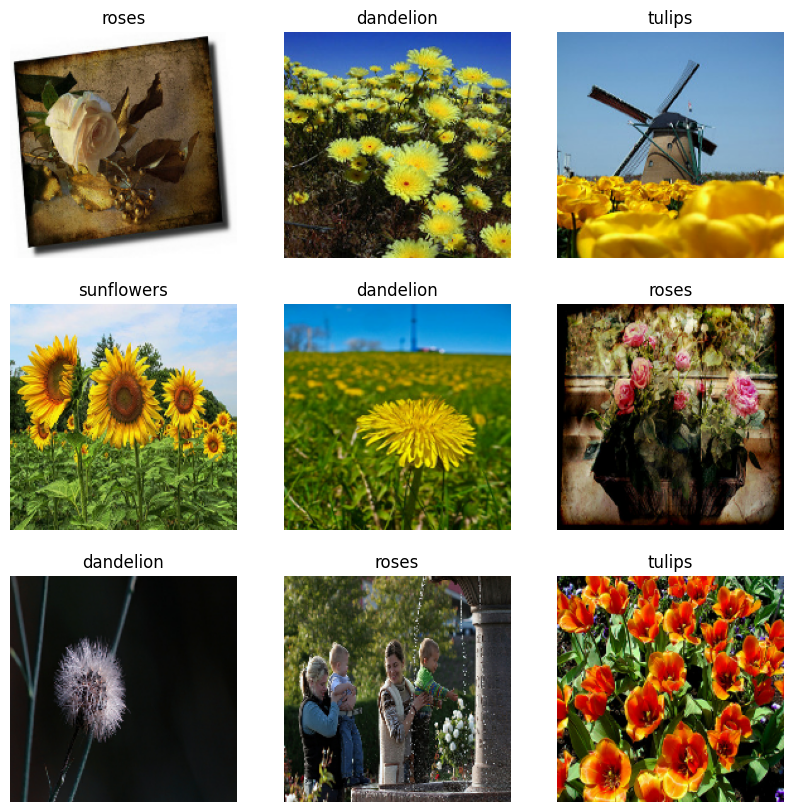

In [ ]:
# Plot the images from the training datasets into a subplot

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

You will pass these datasets to the Keras `Model.fit` method for training later in this tutorial. If you like, you can also manually iterate over the dataset and retrieve batches of images:

In [ ]:
# Optional - If needed to print the shape of the image and labels where,
# - there exists 32 batches of images and size of 180*180 with 3 channels (RGB)
# - Hence it is (32*180*180*3)
# - (32,) - denotes corresponding labels to 32 images as it has 32 as batch size.
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

You can call `.numpy()` on the `image_batch` and `labels_batch` tensors to convert them to a `numpy.ndarray`.


## Configure the dataset for performance

Make sure to use buffered prefetching, so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data:

- `Dataset.cache` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
- `Dataset.prefetch` overlaps data preprocessing and model execution while training.

Interested readers can learn more about both methods, as well as how to cache data to disk in the *Prefetching* section of the [Better performance with the tf.data API](../../guide/data_performance.ipynb) guide.

In [ ]:
# Defines number of parallel calls, adjust based on requirement
# Epoch - defines number of times a model has gone through the dataset
# Eg. - one epoch means that the model has gone through the entire training dataset once

AUTOTUNE = tf.data.AUTOTUNE

# shuffle - done, so that models gets a diverse set of example during each ITERATION/EPOCH
# prefetch - prefetch elements while current iteration is running, better for training, during each epoch
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

# Repeat the same for validation dataset - val_ds
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standardize the data

The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network; in general you should seek to make your input values small.

Here, you will standardize values to be in the `[0, 1]` range by using `tf.keras.layers.Rescaling`:

In [ ]:
# Rescaling [0,255] of standard RGB into [0,1], easy for computation in Convolution Neural Networks
normalization_layer = layers.Rescaling(1./255)

There are two ways to use this layer. You can apply it to the dataset by calling `Dataset.map`:

In [ ]:
# Map each value of normalized layer into y
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
# Gets next batch of data from the iterator, where, it is then resolved into
# - 2 variables which contains normalized input and image labels
image_batch, labels_batch = next(iter(normalized_ds))
# Get the first image from normalised image_batch
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


Or, you can include the layer inside your model definition, which can simplify deployment. Use the second approach here.

Note: You previously resized images using the `image_size` argument of `tf.keras.utils.image_dataset_from_directory`. If you want to include the resizing logic in your model as well, you can use the `tf.keras.layers.Resizing` layer.

## A basic Keras model

### Create the model

The Keras [Sequential](https://www.tensorflow.org/guide/keras/sequential_model) model consists of three convolution blocks (`tf.keras.layers.Conv2D`) with a max pooling layer (`tf.keras.layers.MaxPooling2D`) in each of them. There's a fully-connected layer (`tf.keras.layers.Dense`) with 128 units on top of it that is activated by a ReLU activation function (`'relu'`). This model has not been tuned for high accuracy; the goal of this tutorial is to show a standard approach.

In [ ]:
num_classes = len(class_names)
# Rescale - rescale the image into [0,1] i.e normalize it, along all the 3 channels (RGB)
# 2D Convolution - Carry out convolution with 16, 32, 64 filters with kernel size of 3X3 with activation function
# - of ReLU - Rectified Linear Unit is done in incremental steps after max pooling.
# Max Pooling - In order to reduce the dimension for easy computation, max pooling is used.
# Flatten - Done to flatten the 2D into single dimension array.
# Dense - Fully connected layer with 128 units and activation function as ReLU.

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### Compile the model

For this tutorial, choose the `tf.keras.optimizers.Adam` optimizer and `tf.keras.losses.SparseCategoricalCrossentropy` loss function. To view training and validation accuracy for each training epoch, pass the `metrics` argument to `Model.compile`.

In [ ]:
# Adam Optimizer - Adaptive Moment Estimation - minimize loss function during training of neural networks
# Uses Stochastic Gradient Descent Algorithm with momentum approach
# Used as requires less memory requirements.

# Loss function - SparseCategoricalCrossentropy
# Used to measure, how well the model is performing, it applies softmax function internally.
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Model summary

View all the layers of the network using the Keras `Model.summary` method:

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### Train the model

Train the model for 10 epochs with the Keras `Model.fit` method:

In [ ]:
# Training phase and fit for 10 epochs - train the model for 10 complete iterations

epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
92/92 [==============================] - 15s 39ms/step - loss: 1.4265 - accuracy: 0.4077 - val_loss: 1.1176 - val_accuracy: 0.5395
Epoch 2/10
92/92 [==============================] - 2s 21ms/step - loss: 1.0172 - accuracy: 0.5978 - val_loss: 0.9937 - val_accuracy: 0.6008
Epoch 3/10
92/92 [==============================] - 2s 23ms/step - loss: 0.8565 - accuracy: 0.6669 - val_loss: 0.9876 - val_accuracy: 0.6104
Epoch 4/10
92/92 [==============================] - 2s 23ms/step - loss: 0.6879 - accuracy: 0.7466 - val_loss: 1.0359 - val_accuracy: 0.5995
Epoch 5/10
92/92 [==============================] - 2s 22ms/step - loss: 0.4980 - accuracy: 0.8219 - val_loss: 1.0965 - val_accuracy: 0.6253
Epoch 6/10
92/92 [==============================] - 2s 21ms/step - loss: 0.3286 - accuracy: 0.8873 - val_loss: 1.1848 - val_accuracy: 0.6308
Epoch 7/10
92/92 [==============================] - 2s 22ms/step - loss: 0.1813 - accuracy: 0.9452 - val_loss: 1.5589 - val_accuracy: 0.6117
Epoch 8/10
9

## Visualize training results

Create plots of the loss and accuracy on the training and validation sets:

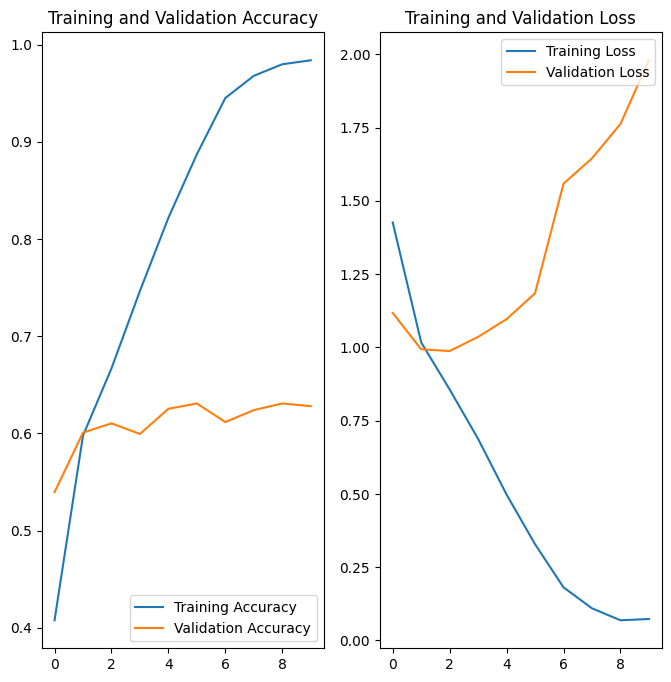

In [ ]:
# Plot the graph of Training vs Validation Accuracy for 0-10 epochs
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plot the graph of Training vs Validation Loss for 0-10 epochs

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

<b>Inference from the graph</b>
<ol>
  <li> Validation accuracy for the graph seems to be at 60%, which are off by huge margins for a model and can be improved further.
  <li> It can be due to Overfitting, where the model is learning from noise and other unwanted detials, which is degrading the accuracy.
  <li> It can be solved by 2 methods
  <ul>
  <li>
  <dl>
      <dt>Data augmentation</dt>
      <dd>- Generates additional training data from existing examples by augmenting them using random transformations that yield believable-looking images.</dd>
      <li><dt>Dropout</dt>
      <dd>- It dropouts a number of output units from the layer during the training process.</dd>
  </dl>
  </ul>
</ol>

## Overfitting

In the plots above, the training accuracy is increasing linearly over time, whereas validation accuracy stalls around 60% in the training process. Also, the difference in accuracy between training and validation accuracy is noticeable—a sign of [overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit).

When there are a small number of training examples, the model sometimes learns from noises or unwanted details from training examples—to an extent that it negatively impacts the performance of the model on new examples. This phenomenon is known as overfitting. It means that the model will have a difficult time generalizing on a new dataset.

There are multiple ways to fight overfitting in the training process. In this tutorial, you'll use *data augmentation* and add *dropout* to your model.

## Data augmentation

In [ ]:
# Apply Data Augmentation to the model
#   - By carrying out random rotation and random zoom across the 3 RGB channels
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

Visualize a few augmented examples by applying data augmentation to the same image several times:

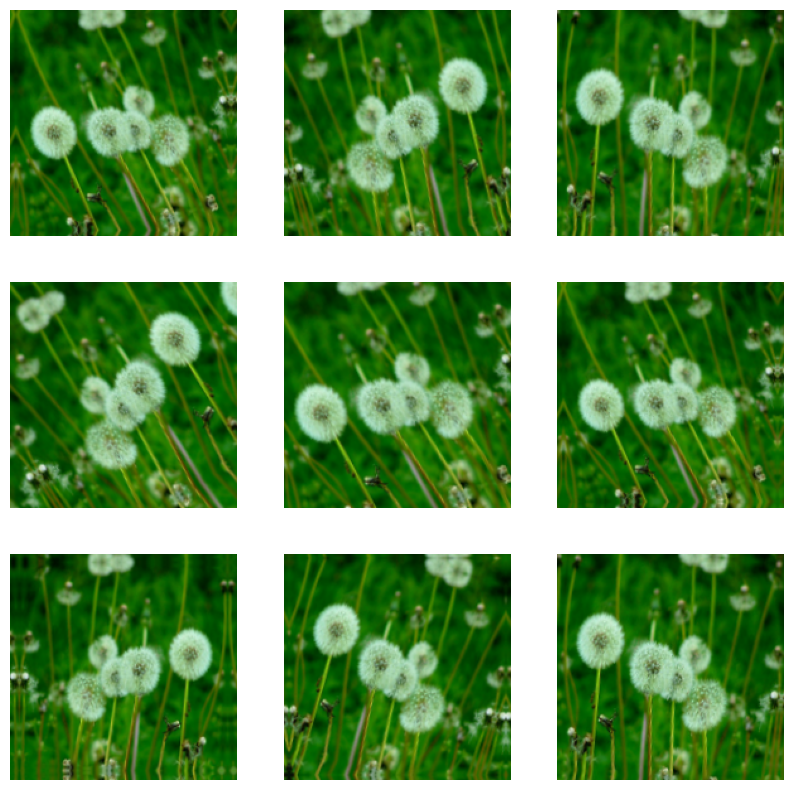

In [ ]:
# Plot the augmented data and display for the trained dataset values

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

You will add data augmentation to your model before training in the next step.

## Dropout

Another technique to reduce overfitting is to introduce [dropout](https://developers.google.com/machine-learning/glossary#dropout_regularization){:.external} regularization to the network.

When you apply dropout to a layer, it randomly drops out (by setting the activation to zero) a number of output units from the layer during the training process. Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer.

Create a new neural network with `tf.keras.layers.Dropout` before training it using the augmented images:

In [ ]:
# Create a new neural network before using the process of dropout
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

## Compile and train the model

In [ ]:
# Use the same adam optimiser and SparseCategoricalCrossentropy for loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
# Display all the values of model
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                 

In [ ]:
# Training phase and fit for 15 epochs - train the model for 10 complete iterations

epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
92/92 [==============================] - 6s 32ms/step - loss: 1.2939 - accuracy: 0.4353 - val_loss: 1.1099 - val_accuracy: 0.5381
Epoch 2/15
92/92 [==============================] - 3s 31ms/step - loss: 1.0229 - accuracy: 0.5960 - val_loss: 0.9747 - val_accuracy: 0.6144
Epoch 3/15
92/92 [==============================] - 3s 32ms/step - loss: 0.9217 - accuracy: 0.6465 - val_loss: 0.9347 - val_accuracy: 0.6349
Epoch 4/15
92/92 [==============================] - 3s 29ms/step - loss: 0.8594 - accuracy: 0.6710 - val_loss: 0.8238 - val_accuracy: 0.6757
Epoch 5/15
92/92 [==============================] - 3s 31ms/step - loss: 0.7912 - accuracy: 0.6884 - val_loss: 0.8769 - val_accuracy: 0.6635
Epoch 6/15
92/92 [==============================] - 3s 30ms/step - loss: 0.7539 - accuracy: 0.7098 - val_loss: 0.9394 - val_accuracy: 0.6512
Epoch 7/15
92/92 [==============================] - 3s 31ms/step - loss: 0.7096 - accuracy: 0.7306 - val_loss: 0.8333 - val_accuracy: 0.6771
Epoch 8/15
92

## Visualize training results

After applying data augmentation and `tf.keras.layers.Dropout`, there is less overfitting than before, and training and validation accuracy are closer aligned:

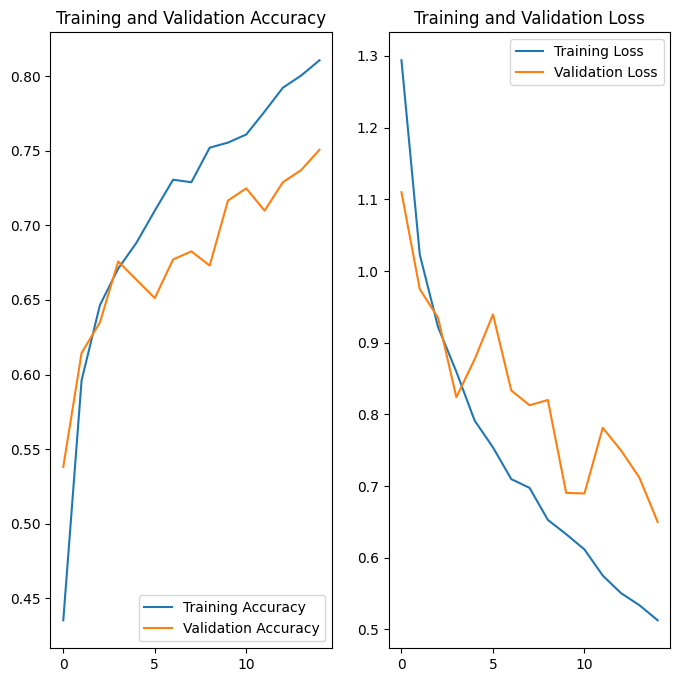

In [ ]:
# Plot the graph of Training vs Validation Accuracy for 0-15 epochs
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plot the graph of Training vs Validation Loss for 0-15 epochs

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Inference from Graph
<ol>
<li>Training accuracy vs validation accuracy has improved after applying Data augmentation and Dropout, denotes model is trained and validated in a better way with better accurate results than earlier.
</ol>

## Predict on new data

Use your model to classify an image that wasn't included in the training or validation sets.

Note: Data augmentation and dropout layers are inactive at inference time.

In [ ]:
# Using our model to to classify an image that wasn't a part of training or validation sets and
# - check whether it produces accurate results.

sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 18ms/step
This image most likely belongs to sunflowers with a 83.10 percent confidence.


## Use TensorFlow Lite

TensorFlow Lite is a set of tools that enables on-device machine learning by helping developers run their models on mobile, embedded, and edge devices.

### Convert the Keras Sequential model to a TensorFlow Lite model

To use the trained model with on-device applications, first [convert it](https://www.tensorflow.org/lite/models/convert) to a smaller and more efficient model format called a [TensorFlow Lite](https://www.tensorflow.org/lite/) model.

In this example, take the trained Keras Sequential model and use `tf.lite.TFLiteConverter.from_keras_model` to generate a [TensorFlow Lite](https://www.tensorflow.org/lite/) model:

In [ ]:
# Convert the model into TensorFlow Lite model from Keraas model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

The TensorFlow Lite model you saved in the previous step can contain several function signatures. The Keras model converter API uses the default signature automatically. Learn more about [TensorFlow Lite signatures](https://www.tensorflow.org/lite/guide/signatures).

### Run the TensorFlow Lite model

You can access the TensorFlow Lite saved model signatures in Python via the `tf.lite.Interpreter` class.

Load the model with the `Interpreter`:

In [ ]:
# Run the TensorFlow Lite model from the default path and interpreter class.

TF_MODEL_FILE_PATH = 'model.tflite' # The default path to the saved TensorFlow Lite model

interpreter = tf.lite.Interpreter(model_path=TF_MODEL_FILE_PATH)

Print the signatures from the converted model to obtain the names of the inputs (and outputs):


In [ ]:
# Get all the signatures from model to get the names of inputs
# inputs - sequential_2_input
# outputs - outputs

interpreter.get_signature_list()

{'serving_default': {'inputs': ['sequential_2_input'], 'outputs': ['outputs']}}

In this example, you have one default signature called `serving_default`. In addition, the name of the `'inputs'` is `'sequential_1_input'`, while the `'outputs'` are called `'outputs'`. You can look up these first and last Keras layer names when running `Model.summary`, as demonstrated earlier in this tutorial.

Now you can test the loaded TensorFlow Model by performing inference on a sample image with `tf.lite.Interpreter.get_signature_runner` by passing the signature name as follows:

In [ ]:
# Need to test the loaded TensorFlow by performing inference on sample image, by passing signature name

classify_lite = interpreter.get_signature_runner('serving_default')
print(classify_lite)

Similar to what you did earlier in the tutorial, you can use the TensorFlow Lite model to classify images that weren't included in the training or validation sets.

You have already tensorized that image and saved it as `img_array`. Now, pass it to the first argument (the name of the `'inputs'`) of the loaded TensorFlow Lite model (`predictions_lite`), compute softmax activations, and then print the prediction for the class with the highest computed probability.

In [ ]:
#Use the TensorFlow Lite model to classify the image that weren't included in training/validation sets.
# Compute the softmax function (activation function) and gives the prediction for class with highest computed probability.
predictions_lite = classify_lite(sequential_2_input=img_array)['outputs']
score_lite = tf.nn.softmax(predictions_lite)

In [ ]:
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score_lite)], 100 * np.max(score_lite))
)

This image most likely belongs to sunflowers with a 83.10 percent confidence.


The prediction generated by the lite model should be almost identical to the predictions generated by the original model:

In [ ]:
print(np.max(np.abs(predictions - predictions_lite)))

9.536743e-07


Of the five classes—`'daisy'`, `'dandelion'`, `'roses'`, `'sunflowers'`, and `'tulips'`—the model should predict the image belongs to sunflowers, which is the same result as before the TensorFlow Lite conversion.


## Next steps

This tutorial showed how to train a model for image classification, test it, convert it to the TensorFlow Lite format for on-device applications (such as an image classification app), and perform inference with the TensorFlow Lite model with the Python API.

You can learn more about TensorFlow Lite through [tutorials](https://www.tensorflow.org/lite/tutorials) and [guides](https://www.tensorflow.org/lite/guide).